In [1]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import wiki_change_factor, make_folium_map

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

---
### Introduction

Our project idea came from the observation that some wikipedia pages seems to get updated a lot after a related events happens. This could be observed during the Catalonia crisis that happened in september-october 2017, Ukraine War in Donbass and many others. We then wondered how we could exploit this information and quickly agreed that those changes could be correlated to a country's stability. Therefore, the project aims to build a stability index for countries using wikipedia data.

#### Maps info
There are folium maps in this notebook. If youre viewing in on Github, open it here to see the maps:<br>
https://nbviewer.jupyter.org/github/Amaumaury/ada-2017/blob/master/project/Milestone2.ipynb


#### Part 1

The first step for our project was then to find evidence of the correlation between events and edits on wikipedia. To tackle this problem we decided to take a special case: the 2014 Ukraine war. Our approach is to show a visual argument (plot) that confirms our intuition.

#### Part 2

Knowing that the causility between events and wikipedia edits existed, we then decided to make a first prototype of our stability index. 

#### Part 3

In this part, we showed the limit of our approach. This let us make a plan for the next milestone

#### Part 4

This part exposes our plan for the next milestone.




---
### Part I - Finding evidence of the implication: main events => lots of wikipedia edits

#### 1 - Find a dataset that contains events for the Ukraine war. 

Intialy we selected the UCDP GED dataset. Unfortunately, as this dataset contains only armed events, we were not able able to find a good visual argument for our intuition. We thus decided to switch to a richer dataset: GDELT events. In order to handle the data, we used a library called **gdeltPyR**.

In [32]:
# Initialize our GDELT fetcher and fetch data
gd1 = gdelt.gdelt(version=1)
results = gd1.Search(['2014 February 01','2014 April 30'],table='events')

In [33]:
# Select events related to Ukraine
ukraine_events = results[results['ActionGeo_CountryCode'] == 'UP']

# Properly format the date for each event
ukraine_events['SQLDATE'] = ukraine_events['SQLDATE'].map(lambda d: pd.Timestamp(str(d)))
ukraine_events = ukraine_events.set_index('SQLDATE')

# Filter out events that are out of our timeframe
ukraine_events = ukraine_events.loc[ukraine_events.index >= pd.Timestamp('20140201')]
ukraine_events = ukraine_events.loc[ukraine_events.index <= pd.Timestamp('20140430')]

# Final holder for our events
ukraine_events_dates = list(ukraine_events.index)

We decided to select only events that occured between 02.01.2014 and 04.30.2014 as this timeframe bounds the beginning of the war.

#### 2 - Grab the history (i.e. edits) of Ukraine's wikipedia page.

In order to grab the edits history for any wikipedia page, we used wikipedia's API and proxied it through our HistoryFetcher class. 

In [34]:
# Fetches Ukraine's wikipedia page history
history_fetcher = HistoryFetcher('Ukraine')
response = history_fetcher.get_history('20140201000000', '20140430000000')

# Keeps only the date field for each edit
ukraine_edits_dates = list(map(lambda revision: revision['timestamp'], response))

#### 3 - Plot the number of edits and events over time

This task was done ploting simple histograms with matplotlib. Both curve are normalized for visibility purposes. 

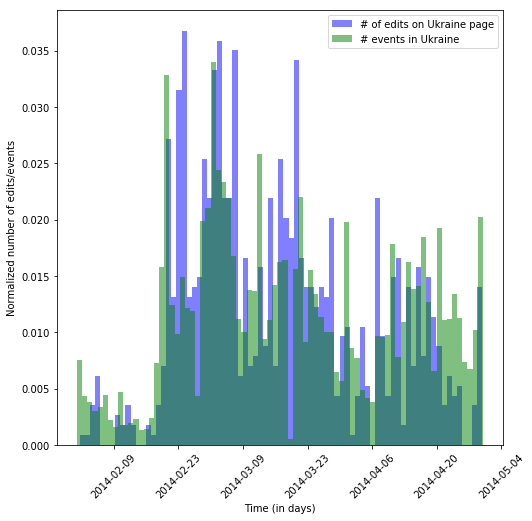

In [35]:
# Add historgram for the number of edits on ukraine's wikipedia page (normalized)
n_wiki, bins_wiki, patches_wiki = plt.hist(ukraine_edits_dates,\
                                           bins=79,\
                                           normed=True,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on Ukraine page')

# Add histogram for the number of events (normalized)
n_event, bins_event, patches_event = plt.hist(ukraine_events_dates,\
                                              bins=79,\
                                              color='green',\
                                              normed=True,\
                                              alpha=0.5,\
                                              label='# events in Ukraine')

plt.xticks(rotation=45)
plt.xlabel('Time (in days)')
plt.ylabel('Normalized number of edits/events')
plt.legend(loc='upper right')
plt.show()

In [36]:
print('Pearson coefficient for our two normalized series is:', np.corrcoef(n_wiki, n_event)[1, 0], '\nThis is a rather high value that emphasize our intuition.')

Pearson coefficient for our two normalized series is: 0.646269617302 
This is a rather high value that emphasize our intuition.


#### Conclusions

This initial investigation, by combining data from two sources, provides arguments towards the causality between events and edits on wikipedia. 

---
### Part II - A prototype for our countries' stability index

With this part we're trying to analyse the rate of wikipedia changes to estimate the stability of the country and its other factors. We believe this analysis is interesting and could draw very interesting conclusions and could also help to find events that causw wikipedia change.

#### Analyzing dynamism of Wikipedia changes

We designed a simple classifier function ( $wiki\_change\_factor(...)$ ) to show how many time wikipedia content varies in time fo a given wikipedia page. Our classifier is based on the mean of the wikipedia changes. If for some month there are number of changes that vary from the mean value too much (more than outlier_factor * mean), we mark this event as "out of normal behaviour" and at the end we sum these events and divide by the whole number of wiki changes for the period.

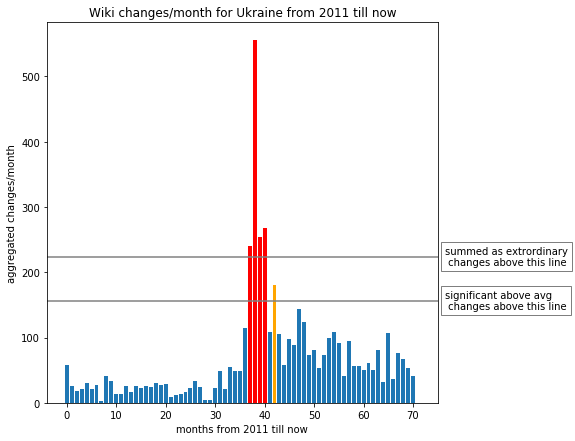

Wikipedia Instability for Ukraine : 0.28529225575


In [3]:
inst_uk = wiki_change_factor('Ukraine', 2011, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Ukraine :', inst_uk)

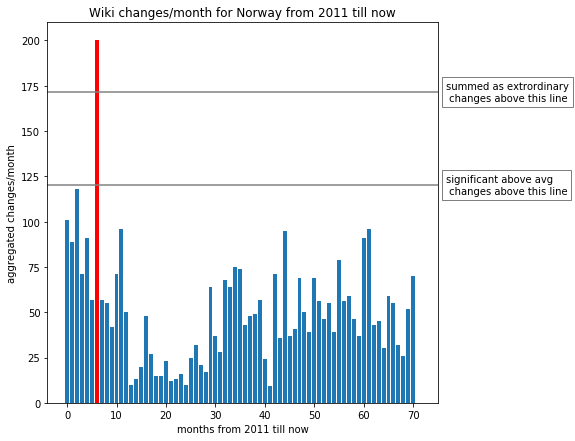

Wikipedia Instability for Norway : (0.055035773252614197, 50.472222222222221)


In [2]:
inst_nr = wiki_change_factor('Norway', 2011, outlier_factor=3.4, plot_on=True)
print('Wikipedia Instability for Norway :', inst_nr)

As we can see above, our classifier is able to detect major events in wikipedia changes and assign a numerical
value to the countries wikipedia stability.

#### Plans:
We're planning to test different classifiers based on derivation to detect different typed of peaks in the data in a different, more error-prone way.

<br>
#### Comparing European Countries
By plotting this coefficient values for different countries in Europe, we can plot a Map with different Wikipedia dynamism rate 

A Jupyter Widget

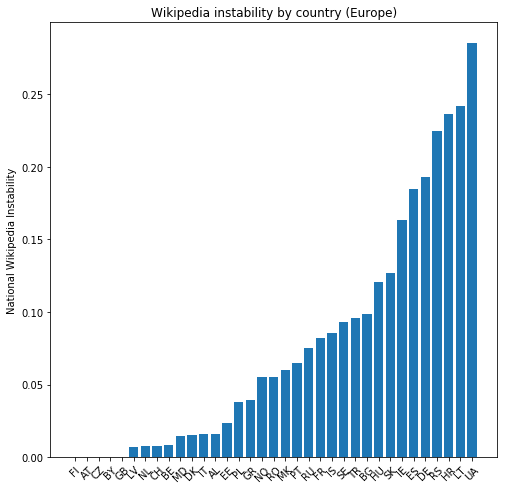

In [209]:
countries = ['Ukraine','Poland','Spain', 'Netherlands','France','Germany','Switzerland','Belgium',
            'Portugal','Italy','Great Britain', 'Ireland', 'Norway', 'Sweden','Denmark',
            'Slovakia','Czech Republic','Austria','Hungary','Croatia','Romania','Greece','Serbia',
            'Macedonia','Albania','Estonia','Latvia','Finland','Lithuania','Russia','Bulgaria','Moldova',
            'Belarus','Turkey','Iceland']

codes = ['UA','PL','ES', 'NL','FR','DE','CH','BE', 'PT','IT','GB','IE','NO','SE','DK',
        'SK','CZ','AT','HU','HR','RO','GR','RS','MK','AL','EE','LV','FI','LT','RU','BG','MD',
        'BY','TR','IS']

wiki_change_values = {}

for i in tqdm_notebook(range(len(countries))):
    wiki_change_values[codes[i]] = wiki_change_factor(countries[i], 2011, outlier_factor = 3.4)

    
sorted_x = sorted(wiki_change_values.items(), key=lambda x: x[1])
values = np.zeros([len(sorted_x),1])
names = ['']*len(sorted_x)

for i in range(len(sorted_x)):
    names[i] = sorted_x[i][0]
    values[i] = sorted_x[i][1]
values= np.squeeze(values)

plt.rcParams["figure.figsize"] = (8,8)
plt.bar(range(len(sorted_x)), values, align='center')
plt.xticks(range(len(sorted_x)), names, rotation=45)
plt.ylabel('National Wikipedia Instability')
plt.title('Wikipedia instability by country (Europe)')
plt.show()

We could observe, that  as expected some very developed and stable countries have very stable wikipedia, and the less stable also less stable wikipedia. However we could observe some interesting facts for some nations:
- Ukraine has lots of instability due to war
- Germany or Croatia has a lot of instability in its wikipedia - to be discovered why, maybe there are some major events to be correlated
- The computed instability factor highly depends on computation method, therefore we should prove better that our method is valid.

#### Wikipedia Instability Map in Europe.
In this part we're showing on the map the previously computed values for Wikipedia Instabilities per country on tha map. 

In [210]:
colors_eu = ['#ffe6d0', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#89000d']
thresh_eu = [0.03      , 0.06      , 0.1      , 0.13     , 0.16     , 0.2     , 0.23     , 0.26]


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = wiki_change_values[state]
    except KeyError:
        return '#bdbdbd'
    
    if np.isnan(val):
        return '#bdbdbd'
    
    length = len(colors_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1]


m = make_folium_map('data/europe2.topojson.json', 'objects.europe',
                    wiki_changes_colors_eu, 0.0, 0.259, colors_eu, 
                    [56,10], 3.5, '% Wiki page instability 2010-2017')

m

In [88]:
nr_internet_people = pd.read_csv('data/nr_people_internet.csv')
cols_to_keep = ['Country or Area','Value']
nr_internet_people = nr_internet_people[cols_to_keep]
nr_internet_people.columns=['Country','Internet Users%']
nr_internet_people.set_index('Country',inplace=True)

nr_all_people = pd.read_csv('data/nr_people_all.csv')
nr_all_people = nr_all_people[nr_all_people['Variant']=='Medium'][cols_to_keep]
cols_to_keep = ['Country or Area','Value']
nr_all_people = nr_all_people[cols_to_keep]
nr_all_people.columns=['Country','Population[k]']
nr_all_people.set_index('Country',inplace=True)


population_data = pd.concat([nr_all_people, nr_internet_people], axis=1, join='inner')
population_data['Internet users[k]'] = population_data['Population[k]'] * population_data['Internet Users%']/100
population_data.head()

countries_data = pd.read_csv('data/country-codes.csv')[1:]
cols_to_keep = ['official_name_en','ISO3166-1-Alpha-3','Least Developed Countries (LDC)','Region Name',
                'Small Island Developing States (SIDS)', 'is_independent']
countries_data = countries_data[cols_to_keep]

# selectbonly independent countires
#countries_data = countries_data[countries_data['is_independent']=='Yes']

#countries_data = countries_data[countries_data['Least Developed Countries (LDC)']!='x']
#countries_data = countries_data[countries_data['Small Island Developing States (SIDS)']!='x']

cols_to_keep = ['official_name_en','ISO3166-1-Alpha-3','Region Name']

countries_data = countries_data[cols_to_keep]
countries_data.columns = ['Country', 'Code','Region']
countries_data['Wiki Instability'] = np.NaN;
countries_data['Wiki mean chang mo'] = np.NaN;
countries_data.set_index('Country',inplace=True)


countries_data = pd.concat([countries_data, population_data], axis=1, join='inner')
countries_data['Big Internet'] = countries_data['Internet users[k]'] > 1000
countries_data.reset_index(inplace=True)

# adding the countires that are missing
import json

geo_data = json.load(open('data/countries.geo.json'))

keys=[k['id'] for k in geo_data['features']]
missing_keys=set(keys)-set(countries_data['Code'])

for k in (missing_keys):
    temp = pd.DataFrame([['', k,'',np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]], columns=countries_data.columns)
    countries_data = countries_data.append(temp, ignore_index=True)

countries_data.head(5)


,Country,Code,Region,Wiki Instability,Wiki mean chang mo,Population[k],Internet Users%,Internet users[k],Big Internet
0,Afghanistan,AFG,Asia,NaN,NaN,35530.081,8.260000,2934.784691,1.0
1,Albania,ALB,Europe,NaN,NaN,2930.187,63.252933,1853.429211,1.0
2,Algeria,DZA,Africa,NaN,NaN,41318.142,38.200000,15783.530244,1.0
3,Andorra,AND,Europe,NaN,NaN,76.965,96.910000,74.586782,0.0
4,Angola,AGO,Africa,NaN,NaN,29784.193,12.400000,3693.239932,1.0


In [92]:
countries_data = pd.read_pickle('countries_data.pkl')


In [93]:
countries_data

,Country,Code,Region,Wiki Instability,Wiki mean chang mo,Population[k],Internet Users%,Internet users[k],Big Internet
0,Afghanistan,AFG,Asia,NaN,68.527778,35530.081,8.260000,2934.784691,1.0
1,Albania,ALB,Europe,NaN,48.777778,2930.187,63.252933,1853.429211,1.0
2,Algeria,DZA,Africa,NaN,17.083333,41318.142,38.200000,15783.530244,1.0
3,Andorra,AND,Europe,NaN,21.972222,76.965,96.910000,74.586782,0.0
4,Angola,AGO,Africa,NaN,7.750000,29784.193,12.400000,3693.239932,1.0
5,Antigua and Barbuda,ATG,Americas,NaN,36.833333,102.012,65.200000,66.511824,0.0
6,Argentina,ARG,Americas,NaN,17.777778,44271.041,69.400921,30724.510200,1.0
7,Armenia,ARM,Asia,NaN,13.097222,2930.450,58.249332,1706.967556,1.0
8,Aruba,ABW,Americas,NaN,31.305556,105.264,88.661227,93.328354,0.0
9,Australia,AUS,Oceania,NaN,31.305556,24450.561,84.560519,20675.521365,1.0


In [146]:
countries = countries_data['Country'].values

codes = countries_data['Code'].values

for i in tqdm_notebook(range(len(countries))):
    # if not already fetched
    try:
        if((np.isnan(countries_data[countries_data['Country']==countries[i] ]['Wiki Instability'].values[0]))):
            change_factor, mean = wiki_change_factor( countries[i], 2011, outlier_factor = 3.4)
            print(countries[i],change_factor, mean)
            countries_data[i-1:i]['Wiki Instability'] = change_factor
            countries_data[i-1:i]['Wiki mean chang mo'] = mean
        else:
            print(countries[i],'Done already')
    except:
        print('skipped: ',countries[i])


A Jupyter Widget

Afghanistan 0.0793103448276 33.0277777778
Albania 0.0161734900689 68.5277777778
Algeria 0.0538154897494 48.7777777778
Andorra 0.0 17.0833333333
Angola 0.00733249051833 21.9722222222
Antigua and Barbuda 0.0637992831541 7.75
Argentina 0.104826546003 36.8333333333
Armenia 0.08578125 17.7777777778
Aruba 0.00784729586426 13.0972222222
Australia 0.0078083407276 31.3055555556
Austria 0.0 31.3055555556
Azerbaijan 0.139603106126 32.1944444444
Bahrain 0.213392857143 28.0
Bangladesh 0.0844978540773 80.9027777778
Barbados 0.00675675675676 20.5555555556
Belarus 0.0 24.5416666667
Belgium 0.00811188811189 39.7222222222
Belize 0.0142714570858 27.8333333333
Benin 0.0137931034483 10.0694444444
Bermuda 0.00695081967213 21.1805555556
Bhutan 0.00691864189622 21.6805555556
Bosnia and Herzegovina 0.0602805132796 46.5416666667
Botswana 0.0 16.2083333333
Brazil 0.189113747383 39.8055555556
Brunei Darussalam nan 0.0
Bulgaria 0.0986803124158 51.5694444444
Burkina Faso 0.246525679758 18.3888888889
Burundi 0.11378

In [181]:
countries_data['Internet users[k]'] = countries_data['Population[k]'] * countries_data['Internet Users%']/100
countries_data['Big Internet'] = (countries_data['Internet users[k]'] > 2000)
countries_data_relevant = countries_data
countries_data_relevant.head()

,Country,Code,Region,Wiki Instability,Wiki mean chang mo,Population[k],Internet Users%,Internet users[k],Big Internet,Wiki contrib ratio,Wiki contrib norm
0,Afghanistan,AFG,Asia,0.016173,68.527778,35530.081,8.260000,2934.784691,True,10.000000,10.000000
1,Albania,ALB,Europe,0.053815,48.777778,2930.187,63.252933,1853.429211,False,10.000000,0.000000
2,Algeria,DZA,Africa,0.000000,17.083333,41318.142,38.200000,15783.530244,True,1.082352,1.082352
3,Andorra,AND,Europe,0.007332,21.972222,76.965,96.910000,74.586782,False,10.000000,0.000000
4,Angola,AGO,Africa,0.063799,7.750000,29784.193,12.400000,3693.239932,True,2.098429,2.098429


In [190]:
countries_data_relevant['Wiki contrib ratio'] = 1000*countries_data_relevant['Wiki mean chang mo'] / countries_data_relevant['Internet users[k]'].values
countries_data_relevant['Wiki contrib norm'] = countries_data_relevant['Wiki contrib ratio'] * (countries_data_relevant['Big Internet'])
countries_data_relevant['Wiki contrib log'] = np.log10(countries_data_relevant['Wiki contrib norm'])
countries_data_relevant.fillna(-3.0, inplace=True)
countries_data_relevant.replace([np.inf, -np.inf], -3.0, inplace=True)
countries_data_relevant.to_pickle('countries_data_relevant.pkl')
countries_data_relevant.sort_values(['Wiki contrib norm'], ascending=0)[70:]

,Country,Code,Region,Wiki Instability,Wiki mean chang mo,Population[k],Internet Users%,Internet users[k],Big Internet,Wiki contrib ratio,Wiki contrib norm,Wiki contrib log
106,Morocco,MAR,Africa,0.006948,14.791667,35739.580,57.080000,20400.152264,True,0.725076,0.725076,-0.139616
79,Japan,JPN,Asia,0.232810,77.805556,127484.450,93.329411,118980.486383,True,0.653935,0.653935,-0.184465
134,Saudi Arabia,SAU,Asia,0.008113,14.722222,32938.213,69.616236,22930.344031,True,0.642041,0.642041,-0.192437
73,Indonesia,IDN,Asia,0.053783,35.791667,263991.379,21.976068,58014.924201,True,0.616939,0.616939,-0.209758
6,Argentina,ARG,Americas,0.085781,17.777778,44271.041,69.400921,30724.510200,True,0.578619,0.578619,-0.237607
116,Nigeria,NGA,Africa,0.055036,50.472222,190886.311,47.442550,90561.334101,True,0.557326,0.557326,-0.253890
30,Canada,CAN,Americas,0.084437,16.777778,36624.199,88.470000,32401.428855,True,0.517810,0.517810,-0.285830
82,Kenya,KEN,Africa,0.072460,10.388889,49699.862,45.622801,22674.468942,True,0.458176,0.458176,-0.338968
102,Mexico,MEX,Americas,0.023889,30.000000,129163.276,57.431043,74179.816570,True,0.404423,0.404423,-0.393165
36,Colombia,COL,Americas,0.059720,8.930556,49065.615,55.904973,27430.118580,True,0.325575,0.325575,-0.487349


In [192]:

m = folium.Map(location=[30, -30],
                   tiles='Mapbox Bright', zoom_start=2.5)

m.geo_json(geo_path=r'data/countries.geo.json', data=countries_data,
             columns=['Code', 'Wiki contrib log'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.5, line_opacity=0.1,
             legend_name='Data Rate ')


m

In [157]:
colors_world = ['#ffe6d0', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#89000d']
thresh_world = [0.5      , 1.50      , 3.5      , 6.5     , 9.5     , 12.5     , 15.5     , 18.5]


def wiki_changes_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    try:
        val = countries_data_relevant[countries_data_relevant['Code'] == state]['Wiki contrib norm'].values[0]
    except KeyError:
        return '#bdbdbd'
    
    if np.isnan(val):
        return '#bdbdbd'
    
    length = len(colors_world)
    for i in range(0, length-1):
        if val < thresh_world[i]:
            return colors_world[i]
    return  colors_world[length-1]


m = make_folium_map('data/countries.geo.json', 'feature.id',
                    wiki_changes_colors_eu, 0.0, 18.5, colors_world, 
                    [56,10], 1.5, '% Wiki page contributions ratio')

m

AttributeError: 'NoneType' object has no attribute 'get'

#### Conclusions to Part II
1. We can see that usually smaller countries has more stable wikipedia --> less things are happening
2. We can observe that in Ukraine there were major changes, probably due to War
3. We can observe that in Spain there were major changes, probably due to Catalonia protest
3. High changes in Germany, Croatia or Lithuania are bizzare, this will be examined in further analysis with events
4. Greece is not being flaged by our index. This is not normal considering the difficulties the country encoutered in 2011

#### Plans
Make the same map for all countries around the world, not only for Europe. 

---
### Part III - Showing the limits

At the moment, our index only considers the main wikipedia page of a country. This is clearly a limitation as information is very coarse grain at this level. Indeed, we are loosing a lot of information on some smaller events that might be interesting to consider like for example the Paris terrorists attack in 2015.

In [15]:
# Fetches France's wikipedia page history
france_history_fetcher = HistoryFetcher('France')
france_history = france_history_fetcher.get_history('20150101000000', '20160101000000')

france_edits_dates = list(map(lambda revision: revision['timestamp'], france_history))

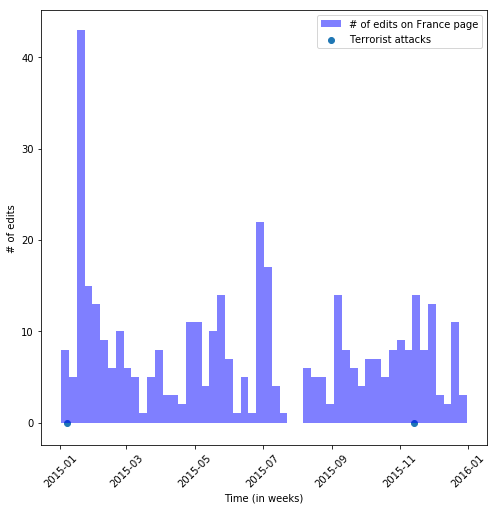

In [31]:
# Add historgram for the number of edits on Frances's wikipedia page
n_wiki, bins_wiki, patches_wiki = plt.hist(france_edits_dates,\
                                           bins=52,\
                                           color='blue',\
                                           alpha=0.5,\
                                           label='# of edits on France page')

# Add the two main terrorists attacks that happened in 2015 on the timeline
plt.scatter([dateutil.parser.parse('20150107'), dateutil.parser.parse('20151113')], [0, 0], label='Terrorist attacks')

plt.xticks(rotation=45)
plt.xlabel('Time (in weeks)')
plt.ylabel('# of edits')
plt.legend(loc='upper right')
plt.show()

First terror attack did not trigger any immediate change on the wikipedia page (remember that each bar correspond to one week). 

Second terror attack could have maybe increased the number of edits but the bump is too low and would be almost impossible to detect automaticaly.

This problem in the resolution of our information motivates one of our objectives for next milestone.

---
### Part IV - Plan for next milestone

As of part 1, we're planning to find more event like this or maybe even semi-automate the process, to check if some event had some effect on wikipedia change rate.

Our priority for next milestone will be to improve our event detector that was exposed in part 2. We will also improve the formula that computes the stability index.

Depending on the time left we will try to improve our countries description using multiple wikipedia pages instead of using only the main one. This will let us have a much better view on the impact of events on any country. 